# Modele generatywne; sieci kodujące-dekodujące

## Sieci kodujące-dekodujące

Jak wiemy z poprzednich zajęć sieci neuronowe pozwalają nam efektywnie zredukować wymiar wejściowego zbioru danych, zazwyczaj w celu odpowiedniej klasyfikacji i predykcji na zadanym zbiorze. Co jednak jeśli jesteśmy zainteresowani tylko redukcją wymiaru danych a nie wnioskowaniem na ich podstawie?

Klasyczna sieć kodująca-dekodująca (<b>autoencoder</b>) pozwala nam na zakodowanie danych (najczęściej obrazu) w formie wektora <b>zmiennych ukrytych</b> <i>(latent variables)</i> i następnie odtworzenie go w możliwie jak najbardziej bezstratnej formie:

[![](http://kvfrans.com/content/images/2016/08/autoenc.jpg)](http://kvfrans.com/variational-autoencoders-explained/)

Idea uczenia takiego modelu polega na zbudowaniu dwóch sieci - kodującej (<i>encoder</i>), która mapuję dane wejściowe do wektora zmiennych ukrytych $z = f(x)$ i sieci dekodującej (<i>decoder</i>), która mapuje wektor zmiennych ukrytych z powrotem na przestrzeń zmiennych wynikowych $x = g(z)$

Tego typu sieci posiadają wiele zastosowań, między innymi:

- Są efektywnym narzędziem kompresji.
- Można je stosować jako sposób szyfrowania danych.
- Umożliwiają odszumienie danych.
- Pozwalają na wykrycie nietrywialnych zależności między danymi, które nie są możliwe do uzyskania za pomocą klasycznych algorytmów uczenia nienadzorowanego.
- Pozwalają na osadzenie złożonych danych w znacznie mniejszej przestrzeni przy niewielkiej stracie informacji.
- Pozwalają na generowanie nowych danych.


Sposób uczenia takiej sieci jest relatywnie prosty - minimalizujemy funkcję straty $L(x,g(f(x)))$. Taki model możemy też regularyzować (np. w celu zapewnienia niskiej wymiarowości embeddingu lub odpowiedniego rozmieszczenia danych w przestrzeni):

$$L(x,g(f(x))) + \Omega(z)$$

W takim wypadku autoenkoder możemy traktować jako formę modelu generatywnego,w którym aproksymujemy estymator największej wiarygodności (<i>Maximum Likelihood Estimation</i>, MLE) bazując na zmiennych ukrytych $z$. Znając $z$ i dane wejściowe $x$ model możemy przedstawić jako:
$$p_{model}(x,z) = p_{model}(z)p_{model}(x|z)$$
gdzie $p_{model}(z)$ to z góry założony rozkład zmiennych ukrytych.

W takim wypadku możemy przedstawić dekoder jako:

$$\log p_{model}(x) = \log \sum_z p_{model}(z)p_{model}(z,x)$$

A uczenie modelu sprowadza się do maksymalizacji wartości wyrażenia:

$$\log p_{model}(z,x) = \log p_{model}(z) + \log p_{model}(x|z)$$

Dlaczego korzystając z autoenkoderów jesteśmy w stanie efektywnie redukować wymiarowość danych?

Zgodnie z <b>hipotezą rozmaitości</b> (<i>Manifold hypothesis</i>) o kształcie  zbiorów danych o wysokim wymiarze decyduje tak naprawdę niewielka liczba zmiennych:

[![](https://www.researchgate.net/profile/Y_Bengio/publication/221700451/figure/fig1/AS:305523212734474@1449853818623/Example-of-a-simple-manifold-in-the-space-of-images-associated-with-a-rather-low-level.png)](https://www.researchgate.net/figure/Example-of-a-simple-manifold-in-the-space-of-images-associated-with-a-rather-low-level_fig1_221700451/)



Pokażmy prosty przykład:

In [1]:
using Flux, MLDatasets
using Flux: mse, throttle, params, Statistics, @epochs
using Base.Iterators: partition
using Printf, BSON, LinearAlgebra
using Flux.Losses
using Plots; gr()
using CUDA

In [2]:
use_cuda = true

true

In [3]:
 if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on GPU
└ @ Main In[3]:3


In [4]:
X, y = MLDatasets.MNIST.traindata(Float32)
N, M = size(X, 3), 64
X = reshape(X,(28^2,N))
data = [X[:,i] for i in Iterators.partition(1:N,M)] |> device;

In [5]:
using Images

In [6]:
encoder = Chain(Dense(28^2, 256, leakyrelu),
                Dense(256, 32, leakyrelu))
    
decoder = Chain(Dense(32, 256, leakyrelu), 
                Dense(256, 28^2))

Chain(
  Dense(32, 256, leakyrelu),            # 8_448 parameters
  Dense(256, 784),                      # 201_488 parameters
)                   # Total: 4 arrays, 209_936 parameters, 820.312 KiB.

In [7]:
model = Chain(encoder, decoder) |> device
loss(x) = mse(model(x), x)
evalcb = throttle(() -> @show(loss(data[1])), 100)
opt = ADAM()

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [8]:
img(x::Vector) = Gray.(transpose(reshape(clamp.(x, 0, 1), 28, 28)))

function sample()
    before = [X[:,i] for i in rand(1:size(X,2), 4)] 
    after = map(x -> model(device(x)), before) |> cpu
    vcat(hcat.(img.(before), img.(after))...)
end

sample (generic function with 1 method)

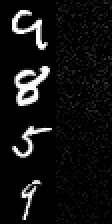

In [9]:
sample()

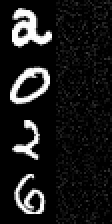

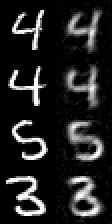

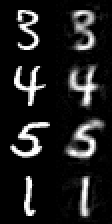

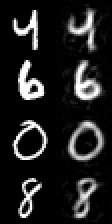

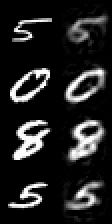

loss(data[1]) = 0.107414775f0


┌ Info: Beginning training loop...
└ @ Main In[10]:1
┌ Info: Epoch 1
└ @ Main In[10]:5
┌ Info: Epoch 2
└ @ Main In[10]:5
┌ Info: Epoch 3
└ @ Main In[10]:5
┌ Info: Epoch 4
└ @ Main In[10]:5
┌ Info: Epoch 5
└ @ Main In[10]:5


In [10]:
@info("Beginning training loop...")
best_ls = Inf
last_improvement = 0
for epoch = 1:5
    @info "Epoch $epoch"
    display(sample())
    global best_ls, last_improvement
    Flux.train!(loss, params(model), zip(data), opt, cb = evalcb)
    ls = loss(data[1])
    if ls <= best_ls
        BSON.@save "enc_dec.bson" model epoch
        best_ls = ls
        last_improvement = epoch
    end
    if epoch - last_improvement >= 2
        @warn(" -> We're calling this converged.")
        break
    end
end

In [11]:
BSON.@load "enc_dec.bson" model 

In [12]:
encoder(X[:,1])

32-element Vector{Float32}:
  0.44514802
 -0.0039715418
  0.22250608
 -0.00038762728
  0.15420373
 -0.0016212252
  0.20443113
  0.19216038
  0.8279902
  0.099020824
 -0.0047532213
  0.4987452
  0.60441935
  ⋮
 -0.0012864721
 -0.00039451345
  0.09907476
 -0.0036561873
 -0.0030352434
  0.10548281
  0.055761747
 -0.0035558122
  0.4328256
  0.47165704
  0.1887148
  0.14954968

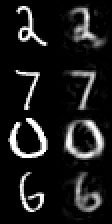

In [13]:
sample()

Taki model pozwala na całkiem efektywną kompresję wejściowych danych. Jednak co należy zrobić gdy chcielibyśmy generować nowe obrazy na podstawie danych wejściowych a nie jedynie je odtwarzać?


##  Wariacyjne autoenkodery

[Variational Autoencoder](https://arxiv.org/pdf/1312.6114.pdf) jest klasą modeli, która na to pozwala. Intuicja  za nimi stojąca jest prosta, sieć dekodująca zamiast odtwarzać obraz w skali 1:1 dodaje do nich pewną losowość, dzięki której wyjściowy obraz jest nieznacznie zmieniony w stosunku do obrazu wejściowego.

Otrzymanie tej losowości jest możliwe dzięki wygenerowaniu przez sieć kodującą nie tyle wektora zmiennych ukrytych, co wektora średnich i odchyleń standardowych zmiennych ukrytych z których następnie losowane są zmienne ukryte wykorzystane przez sieć dekodującą:

[![](http://kvfrans.com/content/images/2016/08/vae.jpg)](http://kvfrans.com/variational-autoencoders-explained/)

Jak działa taka sieć?

Tym co chcemy znaleźć jest rozkład prawdopodobieństwa $p(x,z)$, który wyjaśnia to w jaki sposób zmienne ukryte kształtują dane:

$$p(x,z) = p(x|z)p(z)$$

Po uzyskaniu takiej informacji jesteśmy w stanie efektywnie generować nowe obserwacje:
1. Najpierw poprzez wygenerowanie zmiennych ukrytych z odpowiedniego rozkładu $z_i  \sim p(z)$
2. A następnie nowej obserwacji $x_i \sim p(x|z)$

[![](https://i.stack.imgur.com/w0HP5.png)](https://arxiv.org/pdf/1312.6114.pdf)



Aby wyniki były satysfakcjonujące musimy zbudować model, który będzie umiał efektywnie reprezentować rzeczywiste dane $x$ za pomocą zmiennych ukrytych $z$: 

$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$

Problematyczne jest wyznaczenie wartości $p(x) = \int {p(x|z)p(z)}dz$

Jak to zrobić? 
- bezpośrednio?
- generując dane z rozkladu i uśredniając wyniki?


Zamiast tego mozemy wyaproksymowac $p(z|x)$ za pomocą przyjętego rozkladu $q_{\phi}(z|x)$, który należy do znanej nam rodziny rozkladów prawdopodobieństwa $\phi$. Np. gdy $\phi$ to rodzina rozkładów gaussowskich, wtedy oczywiście zmienne ukryte reprezentujące każdy punkt $x_i$ przyjmują postać: $(\mu_{x_i},\sigma_{x_i})$

Wtedy problem sprowadza się do policzenia::
$$E_{z \sim  q_{\phi}}[p(x | z)]$$ 


Jak jednak $q_{\phi}$ ma sie do $p$?


Mozemy to zmierzyc za pomoca Dywergencji Kullbacka-Leiblera:

$$d_{KL}(q_{\phi}(z|x)||p(z|x)) = E_{q_{\phi}}[\log q_{\phi}(z|x)] - E_{q_{\phi}}[\log p(x,z)] + \log p(x)$$

Za zadanie mamy znaleźć takie $q_{\phi}^*$, które zminimalizuje dywergencje:

$$q_{\phi}^* = \underset{\phi}{\operatorname{argmin}}d_{KL}(q_{\phi}(z|x)||p(z|x))$$

Niestety w wyrażeniu znów pojawia się wartość $p(x)$. Jak w takim razie policzyć stratę dla takiego modelu?

Aby to zrobić zdefiniujmy <b>Evidence Lower BOund</b> (ELBO):

$$ELBO(\phi) = E_{q_{\phi}}[\log p(x,z)] -  E_{q_{\phi}}[\log q_{\phi}(z|x)]$$

Zauważmy, że:

$$\log p(x) = ELBO(\phi) + d_{KL}(q_{\phi}(z|x)||p(z|x))$$

Na mocy nierówności Jensena Dywergencja Kullbacka-Leiblera jest zawsze nieujemna, co oznacza, że problem minimalizacji dywergencji sprowadza się do problemu maksymalizacji ELBO.

Co więcej, wariacyjny autoenkoder posiada tylko lokalne zmienne ukryte, służace do generowania pojedynczych obserwacji. Dzięki czemu możemy wyznaczyć wartość ELBO w pojedynczym punkcie i odpowiednio zagregować wartości:

$$ELBO(\theta,\psi)=\sum_{i=1}^n E_{q_{\phi}(z|x_i;\theta)}[\log p(x_i|z; \psi)] - \sum_{i=1}^n d_{KL}(q(z|x_i; \theta)||p(z))$$


W takim wypadku funkcja straty przyjmuje postać:

$$L(\theta,\psi) = -\sum_{i=1}^n E_{q_{\phi}(z|x_i;\theta)}[\log p(x_i|z; \psi)] + \sum_{i=1}^n d_{KL}(q(z|x_i; \theta)||p(z))$$


Z punktu widzenia sieci neuronowej, wariacyjny autoenkoder możemy traktować jako rodzaj regularyzowanego enkodera.
Pierwszy składnik funkcji straty $\sum_{i=1}^n E_{q_{\phi}(z|x_i;\theta)}[\log p(x_i|z; \psi)]$ możemy traktować jako błąd rekonstrukcji. Chcemy żeby nasz model umiał efektywnie mapować obserwację $x_i$ na zmienne ukryte $z_i$, a następnie odtworzyć je mozliwie najefektywniej, bez utraty jakości. 
Gdybyśmy jednak chcieli uczyć model tylko za pomocą błędu rekonstrukcji sieci byłby on w stanie efektywnie reprezentować instniejące już obserwacje (dane wejściowe), jednak nie byłby w stanie generować nowych obserwacji.

Dlatego do modelu dodajemy dywergecję Kullbacka-Leiblera jako regularyzator. Wymusza on na tak zbudowanym modelu odpowiednie pokrycie przestrzeni zmiennych ukrytych:

[![](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-7.22.24-PM.png)](https://www.jeremyjordan.me/variational-autoencoders/)


Dzięki tym właściwością wariacyjne autoenkodery są doskonałym narzędziem służącym do [redukcji wymiarowości i reprezentacji danych w mniejszych przestrzeniach](https://www.deeplearningbook.org/contents/generative_models.html)

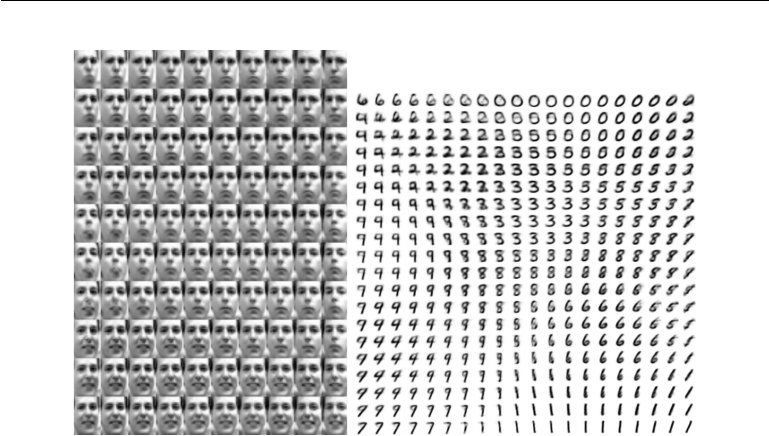

Przejdźmy do implementacji modelu:

In [14]:
X,y = MLDatasets.MNIST.traindata(Float32) 
N, M = size(X, 3), 64
X = reshape(X,(28^2,N)).> 0.5
data = [X[:,i] for i in Iterators.partition(1:N,M)] |> device;

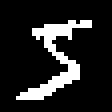

In [15]:
img(Float64.(X[:,1]))

Zdefiniujmy model:

In [16]:
Dz, Dh1, Dh2 = 2, 512, 256 #wymiary

(2, 512, 256)

In [17]:
encoder = Chain(Dense(28^2, Dh1, leakyrelu), Dense(Dh1,Dh2,leakyrelu)) |> device
    
μ = Dense(Dh2, Dz) |> device
lnσ = Dense(Dh2, Dz) |> device 
z(μ, logσ) = μ + exp.(logσ) .* device(randn(Float32,size(logσ)))

decoder = Chain(Dense(Dz, Dh2, leakyrelu),
                Dense(Dh2,Dh1),
                Dense(Dh1, 28^2)) |> device


Chain(
  Dense(2, 256, leakyrelu),             # 768 parameters
  Dense(256, 512),                      # 131_584 parameters
  Dense(512, 784),                      # 402_192 parameters
)                   # Total: 6 arrays, 534_544 parameters, 856 bytes.

I funkcję straty:

In [18]:
# KL-divergence between approximation posterior and N(0, 1) prior
kl_q_p(μ, logσ) = 0.5f0 * sum(@. (exp(2f0 * logσ) + μ^2 -1f0 - 2f0 * logσ))

kl_q_p (generic function with 1 method)

In [19]:
# logp(x|z) - conditional probability of data given latents.
logp_x_z(x, z) = -sum(Losses.logitbinarycrossentropy.(decoder(z), x))

logp_x_z (generic function with 1 method)

In [20]:
function ELBO(X)
    μ̂, logσ̂ = μ(encoder(X)), lnσ(encoder(X))
    ẑ = z(μ̂, logσ̂ )
    (logp_x_z(X, ẑ) * 1 /size(X)[end]) - (kl_q_p(μ̂, logσ̂) * 1 /size(X)[end]) 
    
end

ELBO (generic function with 1 method)

In [21]:
 loss(X) = -ELBO(X)

loss (generic function with 1 method)

In [22]:
 loss(data[1])

544.658f0

Zdefiniujmy wykresy pomocne w uczeniu:

In [23]:
img(x::Vector) = Gray.(transpose(reshape(clamp.(x, 0, 1), 28, 28)))

function sample()
    batch = data[rand(1:length(data))]
    latents = encoder(batch)
    Z = z(μ(latents), lnσ(latents))
    decoded = decoder(Z)
    idx = rand(1:size(batch,2),4)
    before = [img(Float64.(cpu(batch[:,i]))) for i in idx] 
    after = [img(cpu(decoded[:,i])) for i in idx]
    vcat(hcat.(before, after)...)
end

sample (generic function with 1 method)

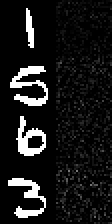

In [24]:
sample()

In [25]:
function scatter_plot(pltsize = 2000)
    plt = scatter(palette=:tab10)
    idxs = rand(1:size(X,2), pltsize)
    labels = y[idxs]
    batch = X[:,idxs] |> device
    μs = μ(encoder(batch)) |> cpu
    scatter!(μs[1, :], μs[2, :], 
            markerstrokewidth=0, markeralpha=0.8,
            aspect_ratio=1,
            markercolor=labels, label="")
end

scatter_plot (generic function with 2 methods)

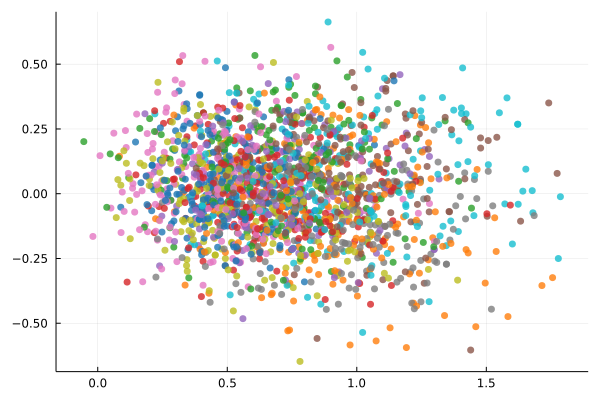

In [26]:
scatter_plot()

In [27]:
function manifold_plot(z = range(-2.0, stop=2.0, length=11))
    len = Base.length(z)
    z1 = repeat(z, len)
    z2 = sort(z1)
    input = hcat(z1,z2)' |> device
    samples = [decoder(input)[:,i] for i = 1:len^2] |> cpu
    samples = reshape(img.(samples), (len,len))
    vcat([hcat(samples[:,i]...) for i = 1:len]...)
end

manifold_plot (generic function with 2 methods)

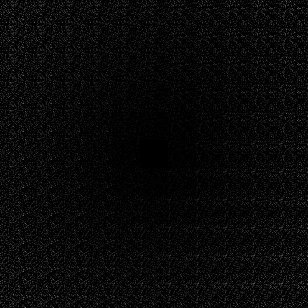

In [28]:
manifold_plot()

In [29]:
function display_plots()
    @show(loss(data[1]))
    display(scatter_plot())
    display(manifold_plot())
    display(sample())
end

display_plots (generic function with 1 method)

Rozpocznijmy uczenie:

In [30]:
evalcb = throttle(display_plots, 900)
opt = ADAM()
ps = params(encoder, μ, lnσ, decoder);

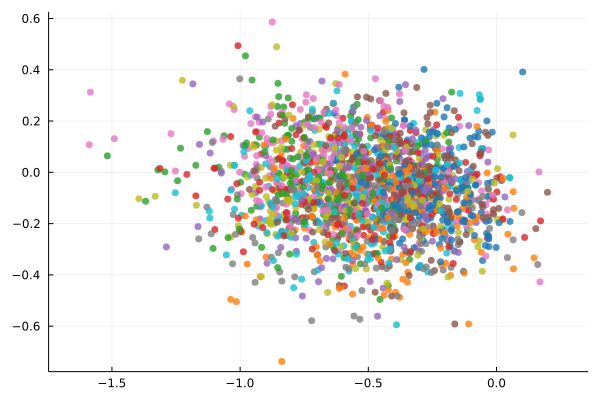

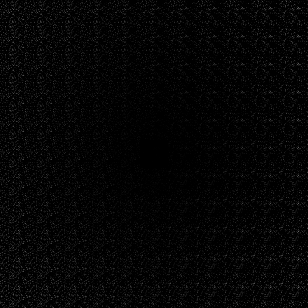

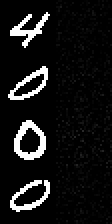

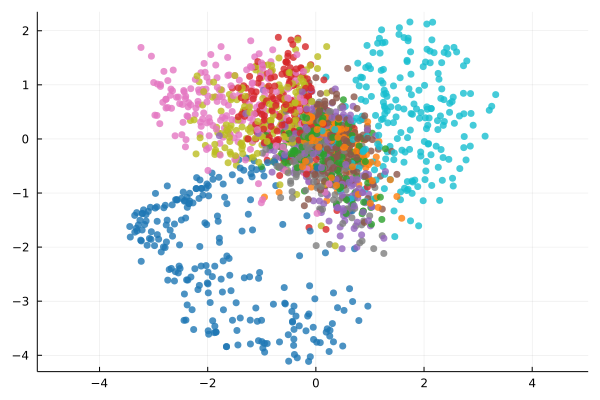

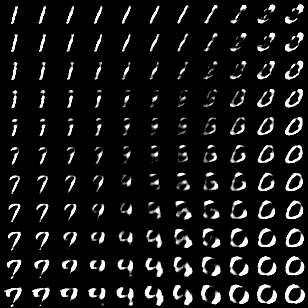

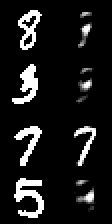

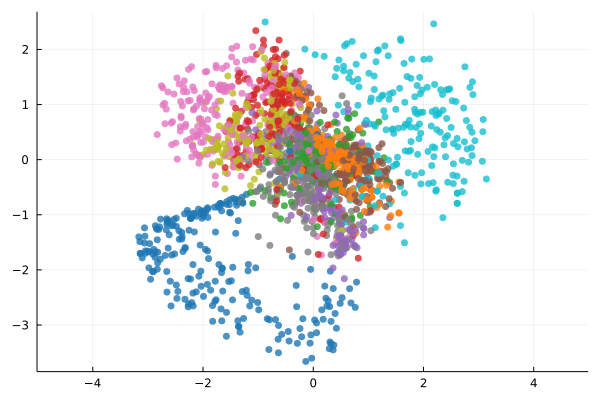

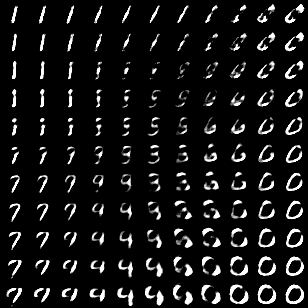

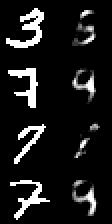

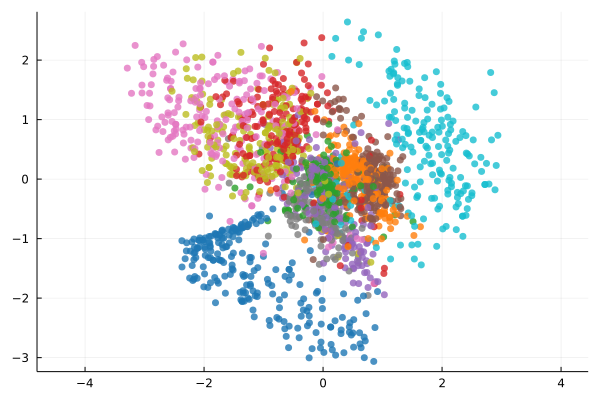

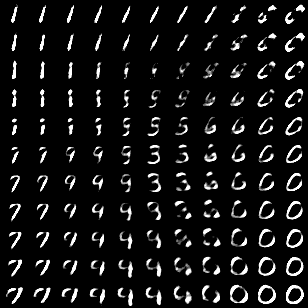

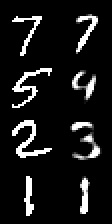

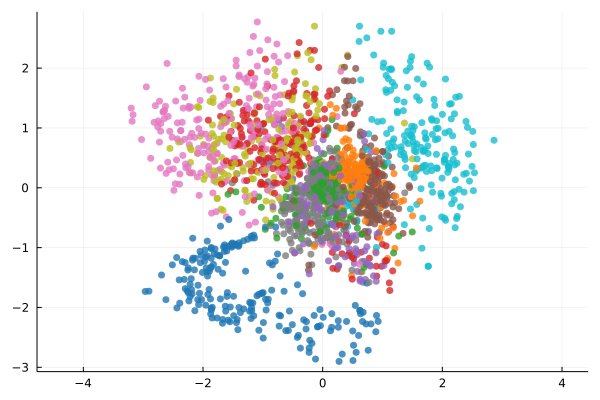

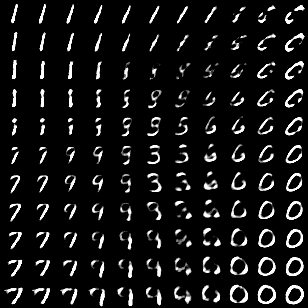

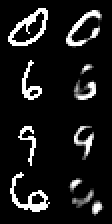

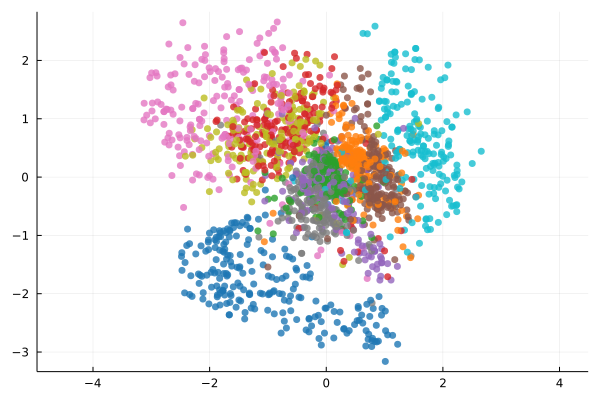

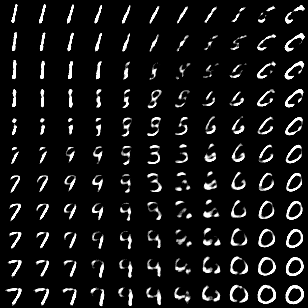

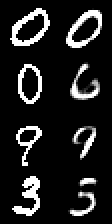

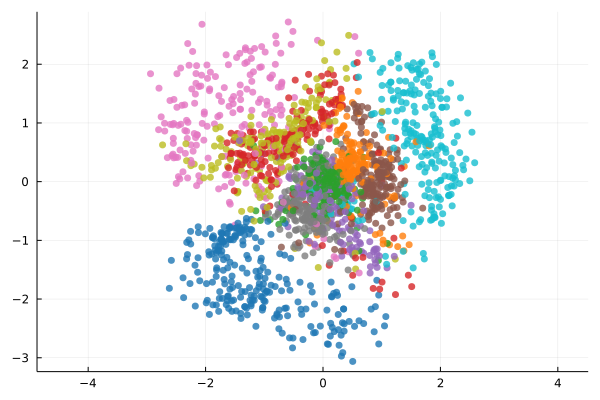

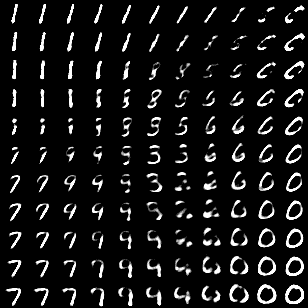

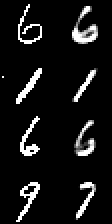

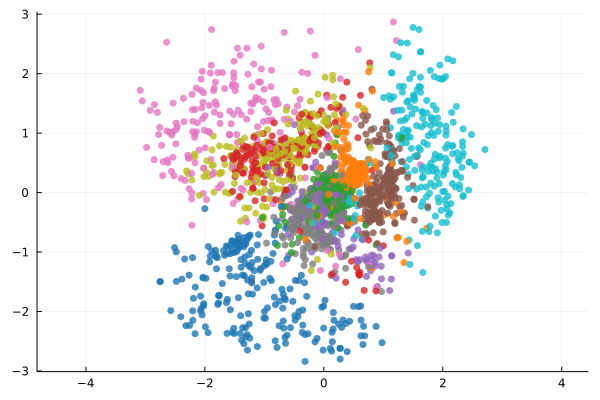

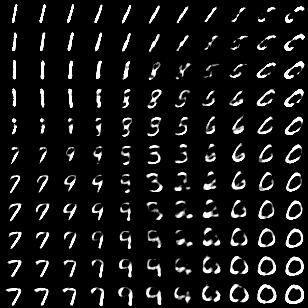

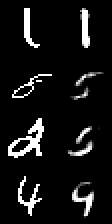

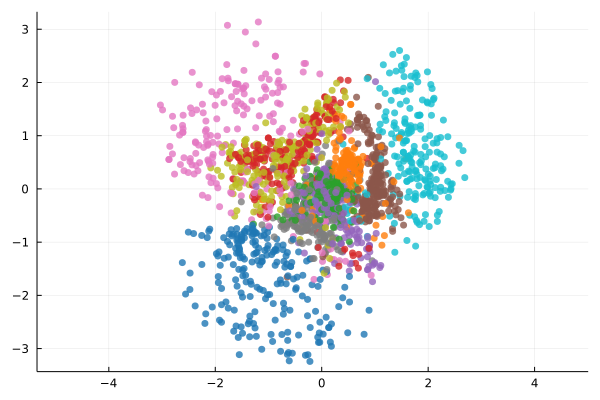

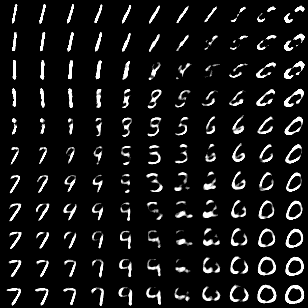

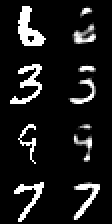

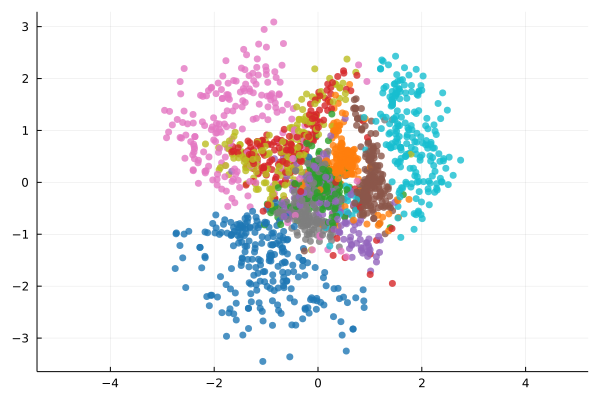

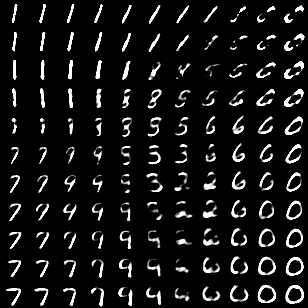

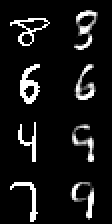

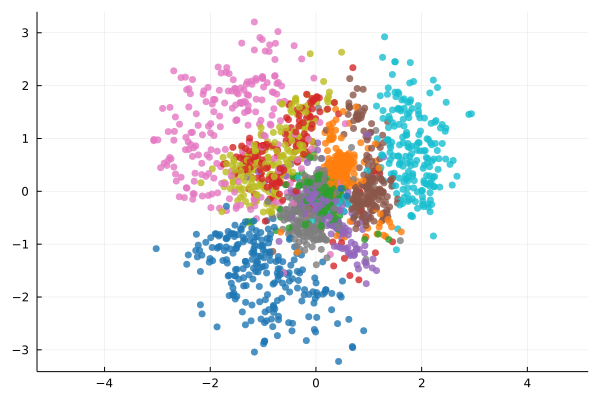

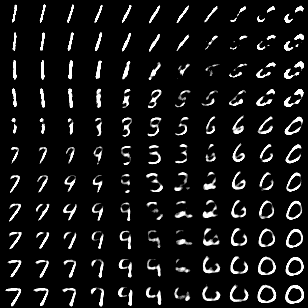

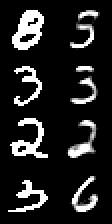

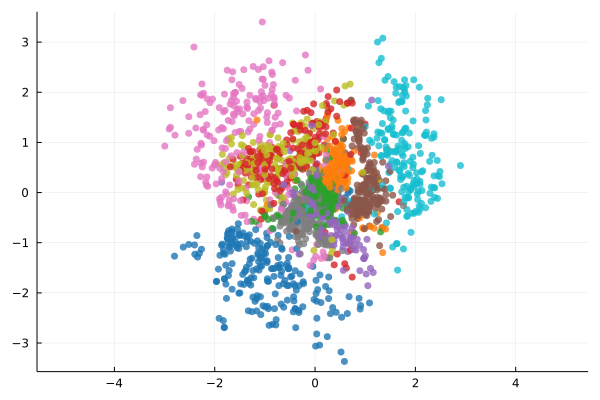

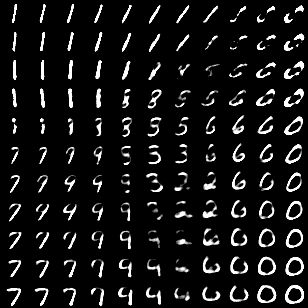

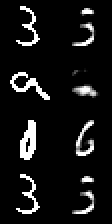

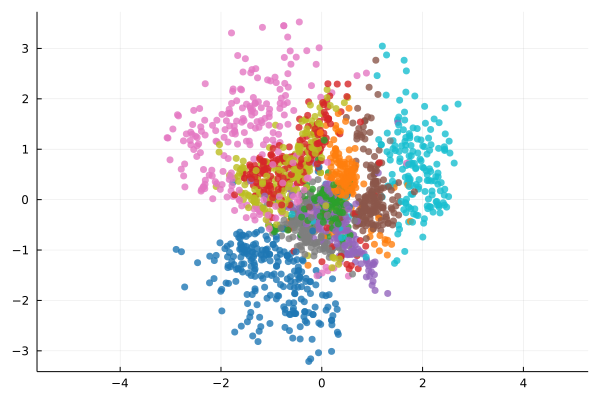

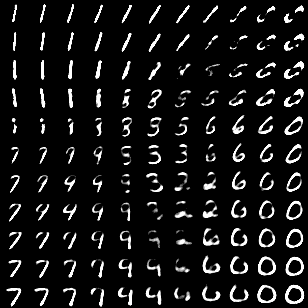

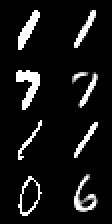

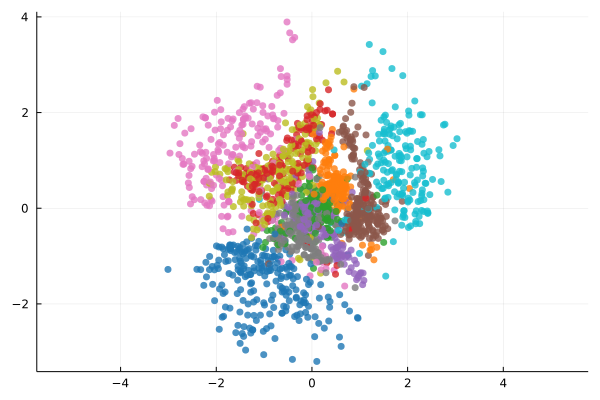

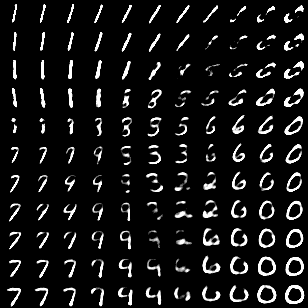

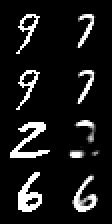

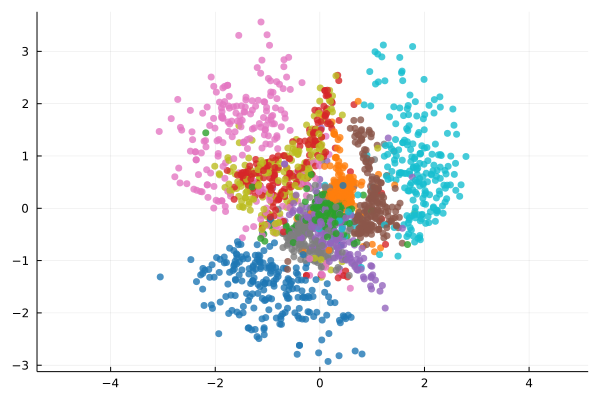

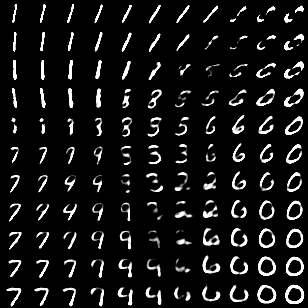

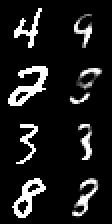

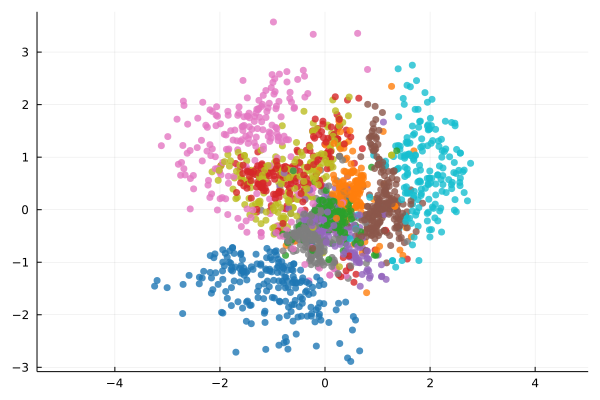

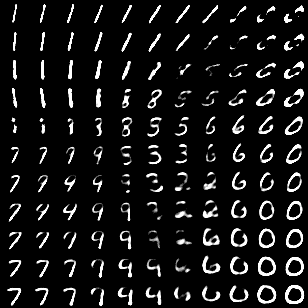

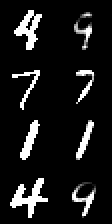

loss(data[1]) = 539.4381f0
loss(data[1]) = 163.61281f0
loss(data[1]) = 157.24026f0
loss(data[1]) = 151.26349f0
loss(data[1]) = 147.29149f0
loss(data[1]) = 144.07022f0
loss(data[1]) = 144.20418f0
loss(data[1]) = 142.78455f0
loss(data[1]) = 141.10356f0
loss(data[1]) = 140.09581f0
loss(data[1]) = 139.45076f0
loss(data[1]) = 138.9458f0
loss(data[1]) = 137.56111f0
loss(data[1]) = 136.82248f0
loss(data[1]) = 136.11105f0
loss(data[1]) = 137.62086f0


┌ Info: Epoch 1
└ @ Main In[31]:5
┌ Info: Epoch 2
└ @ Main In[31]:5
┌ Info: Epoch 3
└ @ Main In[31]:5
┌ Info: Epoch 4
└ @ Main In[31]:5
┌ Info: Epoch 5
└ @ Main In[31]:5
┌ Info: Epoch 6
└ @ Main In[31]:5
┌ Info: Epoch 7
└ @ Main In[31]:5
┌ Info: Epoch 8
└ @ Main In[31]:5
┌ Info: Epoch 9
└ @ Main In[31]:5
┌ Info: Epoch 10
└ @ Main In[31]:5
┌ Info: Epoch 11
└ @ Main In[31]:5
┌ Info: Epoch 12
└ @ Main In[31]:5
┌ Info: Epoch 13
└ @ Main In[31]:5
┌ Info: Epoch 14
└ @ Main In[31]:5
┌ Info: Epoch 15
└ @ Main In[31]:5
┌ Warning:  -> We're calling this converged.
└ @ Main In[31]:16


In [31]:
## @info("Beginning training loop...")
best_ls = Inf
last_improvement = 0
for epoch = 1:20
    @info "Epoch $epoch"
    global best_ls, last_improvement
    Flux.train!(loss, ps, zip(data), opt, cb=evalcb)
    ls = loss(data[1])
    display_plots()
    if ls <= best_ls
        BSON.@save "vae.bson" encoder μ lnσ decoder
        best_ls = ls
        last_improvement = epoch
    end
    if epoch - last_improvement >= 2
        @warn(" -> We're calling this converged.")
        break
    end
end

In [32]:
BSON.@load "vae.bson" encoder μ lnσ decoder 

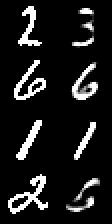

In [33]:
sample()

Do budowania modeli generatywnych możemy wykorzystać też sieci konwolucyjne:

In [ ]:
Dz, Dh = 8, 128 #wymiary

In [ ]:
encoder =  Chain(x -> reshape(x, (28,28,1,size(x)[end])),
        Conv((3,3), 1=>32, pad = (1,1),relu),
        Conv((3,3), 32=>32, pad = (1,1), relu),
        MaxPool((2, 2)),
        Dropout(0.25),
        x -> reshape(x, :, size(x, 4)),
        Dense(6272, Dh)) |> device

μ = Dense(Dh, Dz) |> device

lnσ = Dense(Dh, Dz) |> device

z(μ, logσ) = μ + exp.(logσ) .* device(randn(Float32,size(logσ)))

decoder = Chain(Dense(Dz, Dh, relu),
        Dense(Dh,6272, relu),
        x -> reshape(x,(14,14,32,size(x)[end])),
        Dropout(0.25),
        x -> repeat(x, inner = [2,2,1,1]),
        ConvTranspose((3,3), 32=>32, pad = (1,1),relu),
        ConvTranspose((3,3), 32=>1, pad = (1,1)),
        x -> reshape(x, :, size(x, 4))
       ) |> device

In [ ]:
evalcb = throttle(() -> @show(loss(data[1])), 100)
opt = ADAM()
ps = params(encoder, μ, lnσ, decoder);

In [ ]:
@info("Beginning training loop...")
best_ls = Inf
last_improvement = 0
for epoch = 1:3
    @info "Epoch $epoch"
    display(sample())
    global best_ls, last_improvement
    Flux.train!(loss, ps, zip(data), opt, cb=evalcb)
    ls = loss(data[1])
    if ls <= best_ls
        BSON.@save "vaeCNN_MNIST.bson" encoder μ lnσ decoder
        best_ls = ls
        last_improvement = epoch
    end
    if epoch - last_improvement >= 2
        @warn(" -> We're calling this converged.")
        break
    end
end

In [ ]:
BSON.@load "vaeCNN_MNIST.bson" encoder μ lnσ decoder 

In [ ]:
sample()

## Dodatkowa praca domowa

1. Wykaż, że dywergencja Kullbacka-Leiblera dla dwóch rozkładów normalnych: $\mathcal{N}(\mu,\sigma)$ i $\mathcal{N}(0,1)$ jest równa:

$$d_{KL}(\mathcal{N}(\mu,\sigma)||\mathcal{N}(0,1)) = \frac{1}{2}(\sigma^2 + \mu^2  - 1 - 2\log\sigma) $$ <b>(5 punktów)</b>


2. Popraw prezentowany na zajęciach model, który osadza zbiór MNIST w dwuwymiarowej przestrzeni zmiennych ukrytych. Następnie wyucz ten sam model nie korzystając przy tym z dywergencji KL w funkcji kosztu. Co zauważasz? <b>(8 punktów)</b>